<a href="https://colab.research.google.com/github/Andre6o6/mlcourse-2020/blob/master/LunarLander(DQL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[all] > /dev/null 2>&1
#Need to restart runtime after installing

In [0]:
import base64
import glob
import gym
from gym.wrappers import Monitor
import io
import numpy as np
import random
from IPython.display import HTML
from IPython import display as ipythondisplay

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
def show_video(path):
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))

def wrap_env(env):
    return Monitor(env, 'video/', force=True)

In [4]:
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
for i in range(100):
    env.render()

    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

    if done:
        break
env.close()

In [0]:
path = glob.glob("video/*.mp4")[0]
show_video(path)

In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,action_size)
        )
        
    def forward(self,x):
        return self.net(x)

In [0]:
from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size):
      self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def sample(self, size):
        experiences = random.sample(self.memory, k=size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences])).float()
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences])).long()
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences])).float()
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences])).float()
        return (states,actions,rewards,next_states)

    def __len__(self):
      return len(self.memory)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BUFFER_SIZE = 10000
BATCH_SIZE = 64
UPDATE_RATE = 4

class Agent():
    def __init__(self, state_size, action_size, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma    #discount factor

        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=1e-3)
        self.criterion = nn.MSELoss()

        self.memory = ReplayBuffer(BUFFER_SIZE)
        self.t = 0

    def predict(self, state, eps=0.1):
        if random.random() < eps:
            return random.choice(np.arange(self.action_size))

        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state.to(device))

        return np.argmax(action_values.cpu().numpy())

    def step(self, state, action, reward, next_step, done):
        self.memory.add(state, action, reward, next_step)

        self.t += 1
        if self.t % UPDATE_RATE == 0:
            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample(BATCH_SIZE)
                self.learn(experience)
                
    def learn(self, experiences):
        states, actions, rewards, next_state = experiences

        self.optimizer.zero_grad()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()

        pred = self.qnetwork_local(states.to(device)).gather(1,actions.to(device))
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_state.to(device)).max(1).values.unsqueeze(1)
        labels = rewards.to(device) + (self.gamma*labels_next)

        loss = self.criterion(pred,labels).to(device)
        loss.backward()
        self.optimizer.step()

        self.update_target_network()

    def update_target_network(self, tau=1e-3):
        for target_param, local_param in zip(self.qnetwork_target.parameters(),
                                             self.qnetwork_local.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)

In [12]:
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
observation = env.reset()
agent = Agent(state_size=len(observation),action_size=env.action_space.n)

In [18]:
import tqdm

n_episodes=2000
max_t = 1000

scores = []

for ep in tqdm.trange(n_episodes):
    state = env.reset()
    score = 0
    for t in range(max_t):
        action = agent.predict(state)
        next_state,reward,done,_ = env.step(action)
        agent.step(state,action,reward,next_state,done)

        state = next_state
        score += reward
        if done:
            break
        scores.append(score)

100%|██████████| 1000/1000 [09:26<00:00,  1.77it/s]


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


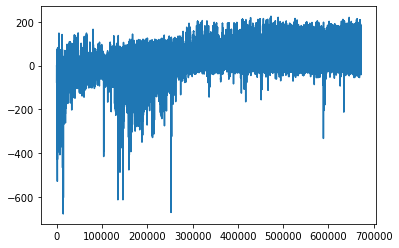

In [19]:
import matplotlib.pyplot as plt
%pylab inline

plt.plot(scores)

In [24]:
env = wrap_env(gym.make("LunarLander-v2"))
state = env.reset()
for i in range(1000):
    env.render()
    action = agent.predict(state)
    state, reward, done, info = env.step(action)

    if done:
        print(reward)
        break
env.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


100


In [25]:
path = glob.glob("video/*.mp4")[0]
show_video(path)